In [1]:
using Distributed
addprocs(6)

using Plots
using LaTeXStrings

# Lucas Schmidt Ferreira de Araujo

# Agent Based Modelling - List 01

## Problem 01

In [2]:
function Burning(nt::Int , L::Int , p::Float64)
    S = zeros(Int,nt,L,L)

    ### Initial condition
    S[1,:,:] = rand(L,L) .< p

    ### Boundary condition
    S[1,:,end-1] *= -1
    
    ### Isolate the domain
    S[1,1,:] .= 0
    S[1,end,:] .= 0
    S[1,:,1] .= 0
    S[1,:,end] .= 0

    ### Iteration
    for q in 1:nt-1
        for j in 2:L-1
            for k in 2:L-1
                cond = S[q,j,k] == 1 && any(x -> x==-1, S[q,j-1:j+1, k-1:k+1])
                S[q+1,j,k] = S[q,j,k]
                if(cond)
                    S[q+1,j,k] = -1
                end
                if(S[q,j,k] == -1)
                    S[q+1,j,k] = 0
                end
            end
        end
    end
    return S
end

function Burn(L::Int , p::Float64)
    f = 0
    S = zeros(Int,L,L)
    
    ### Initial Condition
    S[:,:] = rand(L,L) .< p
  
    ### Isolate the domain
    S[1,:] .= 0
    S[end,:] .= 0
    S[:,1] .= 0
    S[:,end] .= 0
    S0 = copy(S)

    ### Boundary Condition
    S[:,end-1] *= -1

    burning = any(x -> x==-1, S)
    while burning 
        new_S = copy(S)
        for j in 2:L-1
            for k in 2:L-1
                cond = S[j,k] == 1 && any(x -> x==-1, S[j-1:j+1, k-1:k+1])
                if(cond)
                    new_S[j,k] = -1
                end
                if(S[j,k] == -1)
                    new_S[j,k] = 0
                end
            end
        end
        S = new_S
        burning = any(x -> x==-1, S)
    end
    return S , S0
end


function MC(nsim::Int , L::Int , p::Float64)
    f = 0
    for q in 1:nsim
        S , S0 = Burn(L , p) 
        if(S[: , 2] != S0[:,2] )
            f += 1 / nsim
        end
    end
    return f
end

MC (generic function with 1 method)

In [2]:
@everywhere function Burn_prll(L::Int , p::Float64)
    f = 0
    S = zeros(Int,L,L)
    
    ### Initial Condition
    S[:,:] = rand(L,L) .< p

    ### Boundary Condition
    S[:,end-1] *= -1
    
    ### Isolate the domain
    S[1,:] .= 0
    S[end,:] .= 0
    S[:,1] .= 0
    S[:,end] .= 0
    S0 = copy(S)
    
    burning = any(x -> x==-1, S)
    while burning 
        new_S = copy(S)
        for j in 2:L-1
            for k in 2:L-1
                cond = S[j,k] == 1 && any(x -> x==-1, S[j-1:j+1, k-1:k+1])
                if(cond)
                    new_S[j,k] = -1
                end
                if(S[j,k] == -1)
                    new_S[j,k] = 0
                end
            end
        end
        S = new_S
        burning = any(x -> x==-1, S)
    end
    return S , S0
end


@everywhere function MC_prll(nsim::Int , L::Int , p::Float64)
    f = @distributed (+) for q in 1:nsim
        S , S0 = Burn_prll(L , p) 
        if(S[: , 2] != S0[:,2] )
             1 / nsim
        else
            0
        end
    end
    return f
end

┌ Info: Saved animation to /tmp/jl_w1u9M1Ut4b.gif
└ @ Plots /home/lucas/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_w1u9M1Ut4b.gif")
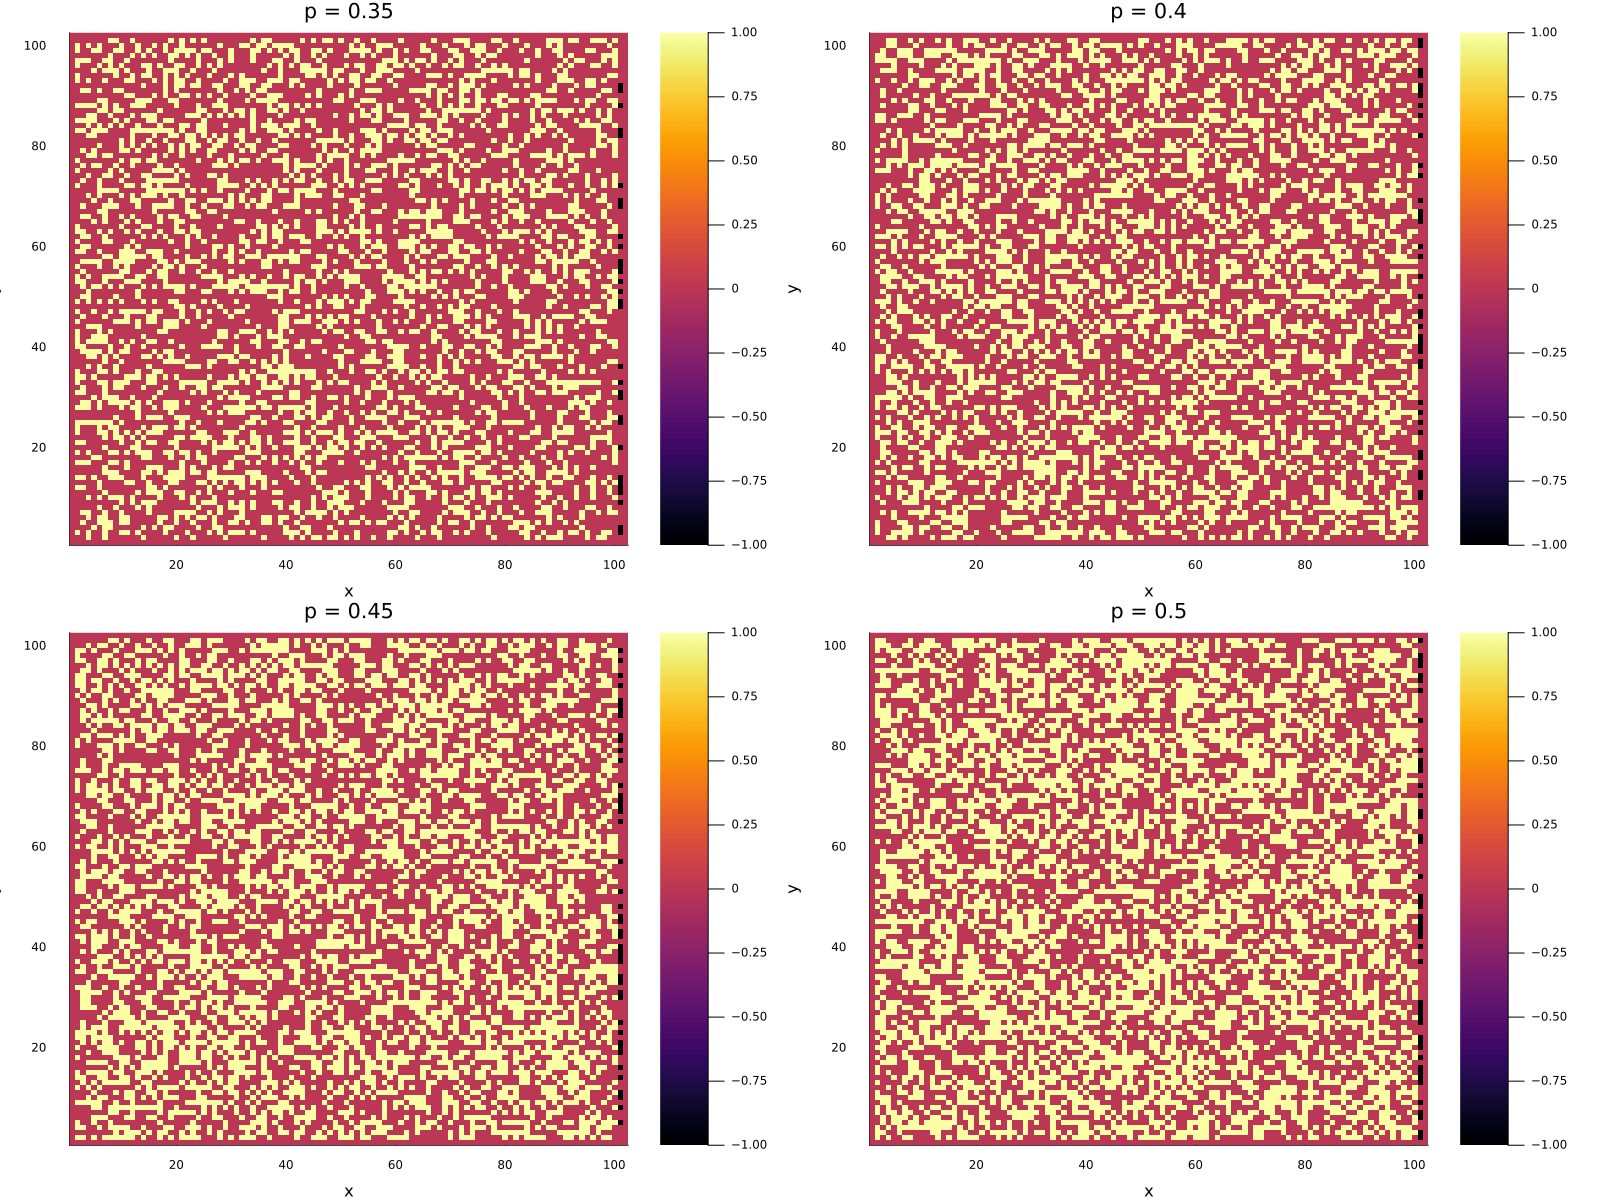

In [10]:
L = 100+2
nt = 2*L

S1 = Burning(nt,L,.35)
S2 = Burning(nt,L,.4)
S3 = Burning(nt,L,.45)
S4 = Burning(nt,L,.5)

anim = @animate for q in 1:nt
    p1 = heatmap(S1[q,:,:] , xlabel = "x" , ylabel = "y" , title = "p = $(0.35)" , clim = (-1,1))
    p2 = heatmap(S2[q,:,:] , xlabel = "x" , ylabel = "y" , title = "p = $(0.4)" , clim = (-1,1))
    p3 = heatmap(S3[q,:,:] , xlabel = "x" , ylabel = "y" , title = "p = $(0.45)" , clim = (-1,1))
    p4 = heatmap(S4[q,:,:] , xlabel = "x" , ylabel = "y" , title = "p = $(0.5)" , clim = (-1,1))
    plot(p1,p2,p3,p4 , layout = (2,2) , size = (1600 , 1200) )
end
gif(anim)

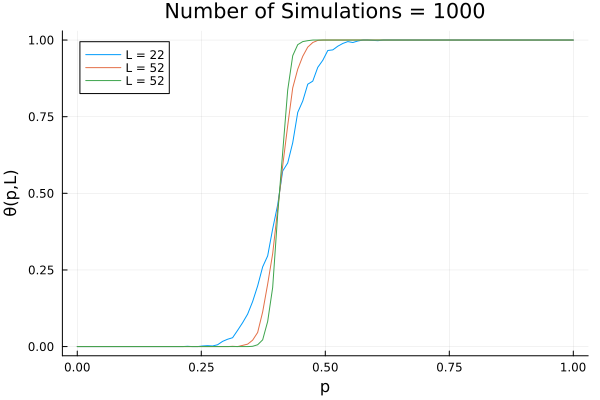

In [3]:
nsim = 1000
L1 = 20 + 2 
L2 = 50 + 2
L3 = 100 + 2
p = range(0,1,100)
freq1 = map(x -> MC_prll(nsim,L1,x) , p)
freq2 = map(x -> MC_prll(nsim,L2,x) , p)
freq3 = map(x -> MC_prll(nsim,L3,x) , p)

plot(p,freq1 , label = "L = $(L1)")
plot!(p,freq2 , label = "L = $(L2)")
plot!(p,freq3 , label = "L = $(L2)")
xlabel!("p")
ylabel!("θ(p,L)")
title!("Number of Simulations = $(nsim)")

b.)

In [36]:
function HKA(B::Matrix{Int})
    """
    Implementation of the Hoshen-Kopelman algorithm
    """

    nx , ny = size(B)
    last_label = 1
    label = ones( Int , nx , ny)
    labels = collect(1:nx * ny) 
    
    function find(x::Int)
        y = x
        while labels[y] != y
            y = labels[y]
        end
        while labels[x] != x
            z = labels[x]
            labels[x] = y
            x = z
        end
        return y
    end
    
    function union(x::Int, y::Int)
        labels[find(x)] = find(y)
    end

    for x in 2:nx-1
        for y in 2:ny-1
            if( B[x,y] == -1 )
                left = label[x,y-1]
                above = label[x-1,y]
                if(left == 1 && above ==1)
                    last_label += 1
                    label[x,y] = last_label
                elseif( left != 1 && above == 1 )
                    label[x,y] = find(left)
                elseif( left == 1 && above != 1 )
                    label[x,y] = find(above)
                else
                    union(left,above)
                    label[x,y] = find(left)
                end
            end
        end
    end
    
    for x in 2:nx-1
        for y in 2:ny-1
            if label[x, y] != 1
                label[x, y] = find(label[x, y])
            end
        end
    end
    return label .- 1
end

function getMaxSize( Clusters )
    size = 0
    for q in unique(Clusters)[2:end]
        size_ = length( lenClusters[ Clusters == q ] ) 
        size <  size_ ? size = size_ : 0 
    end
    return size
end

function MC_Size(nsim::Int , L::Int , p::Float64)
    avgsize = 0
    for q in 1:nsim
        S , S0 = Burn(L , p)
        B = S - S0
        Clusters = HKA(B) 
        avgsize += getMaxSize(Clusters)
    end
    return avgsize
end

HKA (generic function with 1 method)

In [19]:
@everywhere function HKA_prll(B::Matrix{Int})
    """
    Implementation of the Hoshen-Kopelman algorithm
    """

    nx , ny = size(B)
    last_label = 1
    label = ones( Int , nx , ny)
    labels = collect(1:nx * ny) 
    
    function find(x::Int)
        y = x
        while labels[y] != y
            y = labels[y]
        end
        while labels[x] != x
            z = labels[x]
            labels[x] = y
            x = z
        end
        return y
    end
    
    function union(x::Int, y::Int)
        labels[find(x)] = find(y)
    end

    for x in 2:nx-1
        for y in 2:ny-1
            if( B[x,y] == -1 )
                left = label[x,y-1]
                above = label[x-1,y]
                if(left == 1 && above ==1)
                    last_label += 1
                    label[x,y] = last_label
                elseif( left != 1 && above == 1 )
                    label[x,y] = find(left)
                elseif( left == 1 && above != 1 )
                    label[x,y] = find(above)
                else
                    union(left,above)
                    label[x,y] = find(left)
                end
            end
        end
    end
    
    for x in 2:nx-1
        for y in 2:ny-1
            if label[x, y] != 1
                label[x, y] = find(label[x, y])
            end
        end
    end
    return label .- 1
end

@everywhere function getMaxSize_prll( Clusters::Matrix{Int} )
    size = 0
    for q in unique(Clusters)[2:end]
        size_ = length( Clusters[ Clusters .== q ] ) 
        size <  size_ ? size = size_ : 0 
    end
    return size
end

@everywhere  function MC_Size_prll(nsim::Int , L::Int , p::Float64)
    avgsize = @distributed (+) for q in 1:nsim
        S , S0 = Burn_prll(L , p)
        B = S - S0
        Clusters = HKA_prll(B) 
        
        getMaxSize_prll(Clusters) / nsim
    end
    return avgsize
end

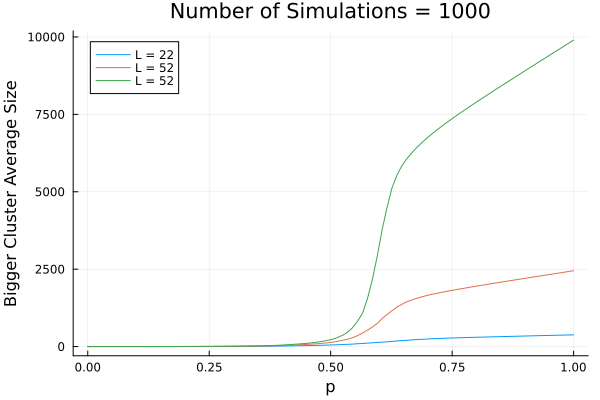

In [21]:
nsim = 1000
L1 = 20 + 2 
L2 = 50 + 2
L3 = 100 + 2
p = range(0,1,100)
avgsize1 = map(x -> MC_Size_prll(nsim,L1,x) , p)
avgsize2 = map(x -> MC_Size_prll(nsim,L2,x) , p)
avgsize3 = map(x -> MC_Size_prll(nsim,L3,x) , p)

plot(p,avgsize1 , label = "L = $(L1)")
plot!(p,avgsize2 , label = "L = $(L2)")
plot!(p,avgsize3 , label = "L = $(L2)")
xlabel!("p")
ylabel!("Bigger Cluster Average Size")
title!("Number of Simulations = $(nsim)")

### Wind Effect

In [12]:
function Burning_Wind(nt::Int , L::Int , p::Float64 , w::Vector{Int} , s::Vector{Float64})
    S = zeros(Int,nt,L,L)

    ### Initial condition
    S[1,:,:] = rand(L,L) .< p

    ### Boundary condition
    S[1,:,end-1] *= -1
    
    ### Isolate the domain
    S[1,1,:] .= 0
    S[1,end,:] .= 0
    S[1,:,1] .= 0
    S[1,:,end] .= 0

    ### Iteration
    for q in 1:nt-1
        S[q+1,:,:] = copy(S[q,:,:])
        for j in 2:L-1
            for k in 2:L-1
                #S[q+1,j,k] = S[q,j,k]
                if(S[q,j,k] == -1)
                    S_ = S[q,j-1:j+1, k-1:k+1]
                    for m in 1:3
                        for n in 1:3
                            if(S_[m,n] == 1)
                                bd = [n-2 , 2-m]
                                u = w .* bd
                                px , py = .5 .+ s .* u .* .5 
                                if( px > rand() || py > rand()  )
                                    S[q+1 , j + (m-2) , k + (n-2) ] = -1
                                end
                                
                            elseif(S_[m,n] == -1)
                                S[q+1 , j + (m-2) , k + (n-2) ] = 0
                            end
                        end
                    end
                end
            end
        end
    end
    return S
end

Burning_Wind (generic function with 1 method)

In [2]:
@everywhere function Burn_Wind(L::Int , p::Float64 , w::Vector{Int} , s::Vector{Float64})
    S = zeros(Int,L,L)

    ### Initial condition
    S[:,:] = rand(L,L) .< p

    ### Isolate the domain
    S[1,:] .= 0
    S[end,:] .= 0
    S[:,1] .= 0
    S[:,end] .= 0
    S0 = copy(S)
    
    ### Boundary condition
    S[:,end-1] *= -1

    ### Iteration
    burning = any(x -> x==-1, S)
    while burning
        new_S = copy(S[:,:])
        for j in 2:L-1
            for k in 2:L-1
                if(S[j,k] == -1)
                    S_ = S[j-1:j+1, k-1:k+1]
                    for m in 1:3
                        for n in 1:3
                            if(S_[m,n] == 1)
                                bd = [n-2 , 2-m]
                                u = w .* bd
                                px , py = .5 .+ s .* u .* .5 
                                if( px > rand() && py > rand()  )
                                    new_S[j + (m-2) , k + (n-2) ] = -1
                                end
                            elseif(S_[m,n] == -1)
                                new_S[j + (m-2) , k + (n-2) ] = 0
                            end
                        end
                    end
                end
            end
        end
        S = new_S
        burning = any(x -> x==-1, S)
    end

    return S , S0
end


@everywhere function MC_prll_wind(nsim::Int , L::Int , p::Float64)
    f = @distributed (+) for q in 1:nsim
        S , S0 = Burn_Wind(L , p , w , s) 
        if(S[: , 2] != S0[:,2] )
             1 / nsim
        else
            0
        end
    end
    return f
end

┌ Info: Saved animation to /tmp/jl_KVIpyROFWl.gif
└ @ Plots /home/lucas/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_KVIpyROFWl.gif")
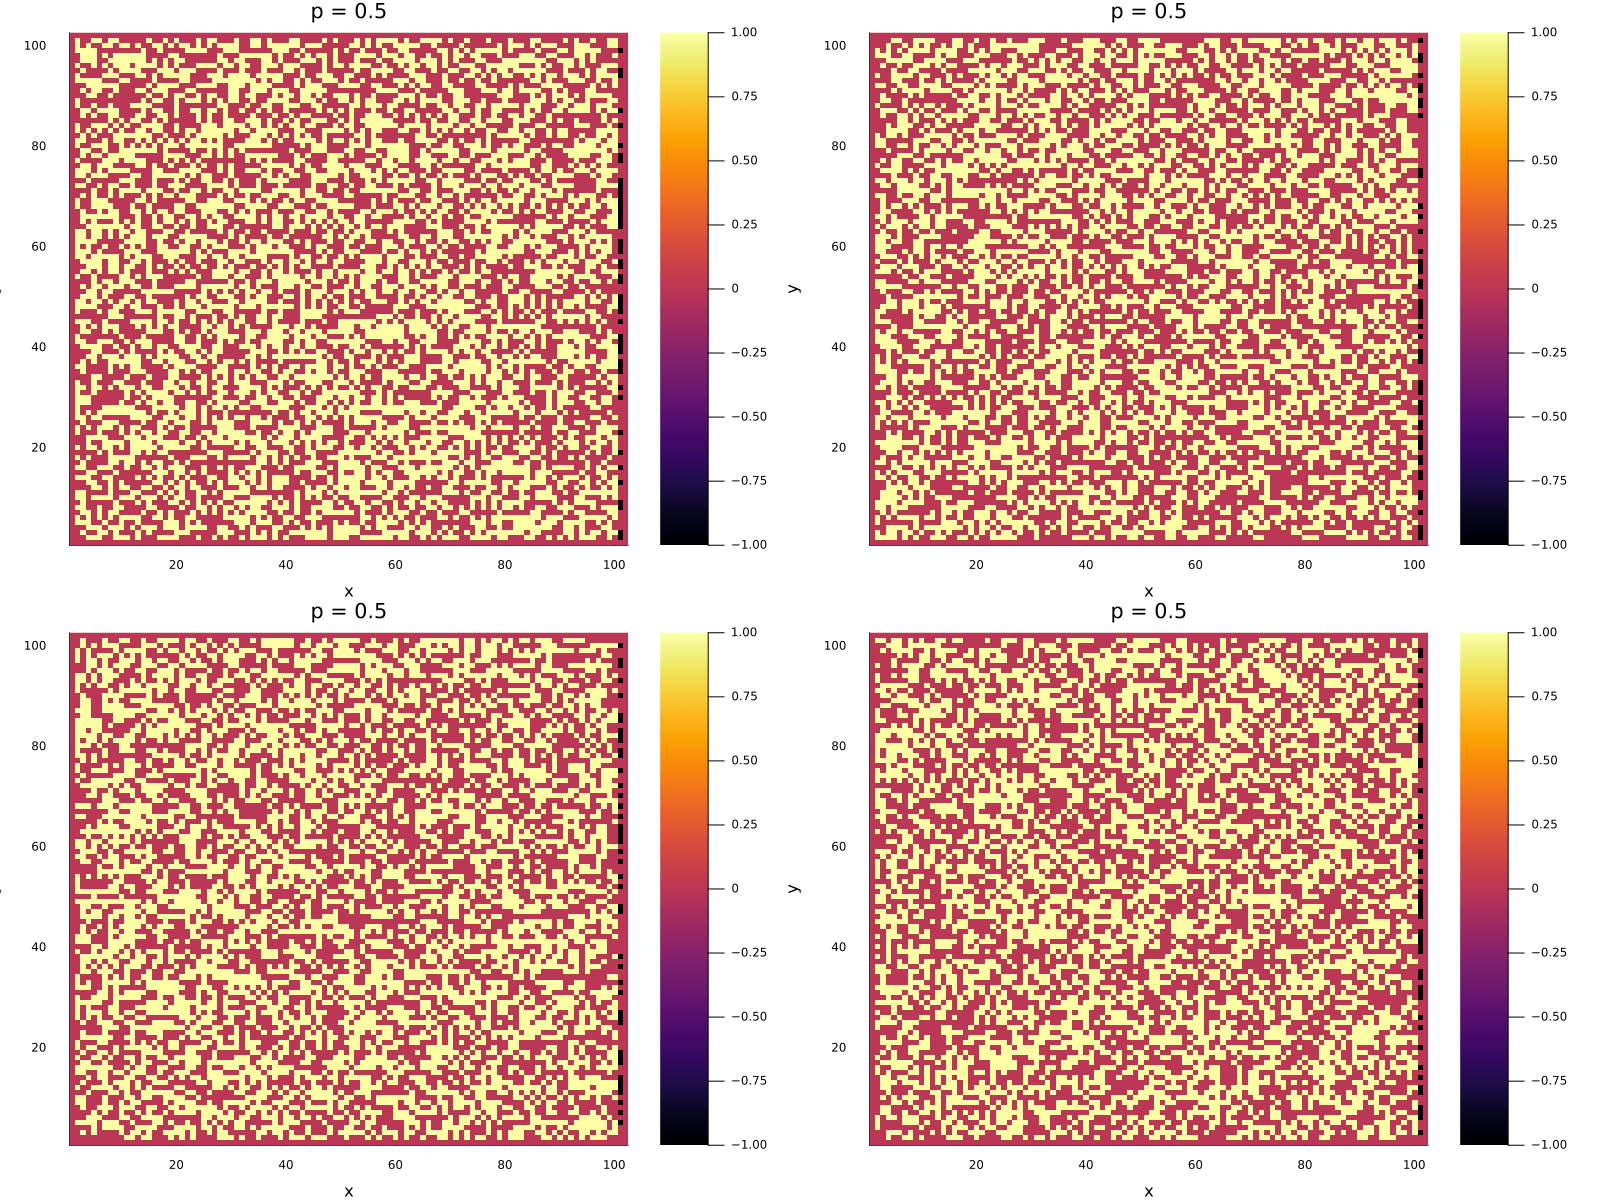

In [14]:
nt = 200
L = 100+2
s = [1.0,1.0]

S1 = Burning_Wind(nt,L,.5, [-1,-1] ,s)
S2 = Burning_Wind(nt,L,.5, [-1,0],s)
S3 = Burning_Wind(nt,L,.5,[1,-1],s)
S4 = Burning_Wind(nt,L,.5,[1,0],s)

anim = @animate for q in 1:nt
    p1 = heatmap(S1[q,:,:] , xlabel = "x" , ylabel = "y" , title = "p = $(0.5)" , clim = (-1,1))
    p2 = heatmap(S2[q,:,:] , xlabel = "x" , ylabel = "y" , title = "p = $(0.5)" , clim = (-1,1))
    p3 = heatmap(S3[q,:,:] , xlabel = "x" , ylabel = "y" , title = "p = $(0.5)" , clim = (-1,1))
    p4 = heatmap(S4[q,:,:] , xlabel = "x" , ylabel = "y" , title = "p = $(0.5)" , clim = (-1,1))
    plot(p1,p2,p3,p4 , layout = (2,2) , size = (1600 , 1200) )
end

gif(anim)

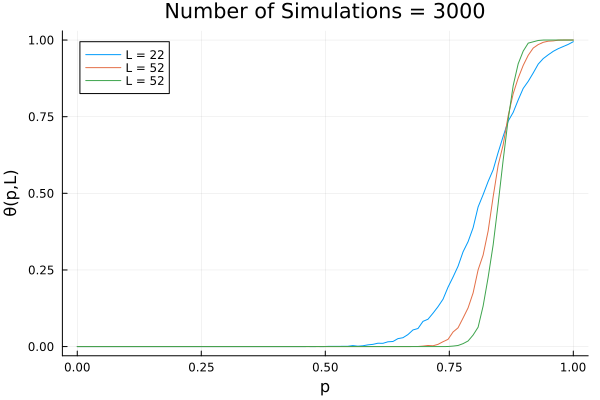

In [11]:
nsim = 3000
L1 = 20 + 2 
L2 = 50 + 2
L3 = 100 + 2
w = [-1,-1]
s = [0.5,0.4]

p = range(0,1,100)
freq1 = map(x -> MC_prll_wind(nsim,L1,x) , p)
freq2 = map(x -> MC_prll_wind(nsim,L2,x) , p)
freq3 = map(x -> MC_prll_wind(nsim,L3,x) , p)

p1 = plot(p,freq1 , label = "L = $(L1)")
plot!(p,freq2 , label = "L = $(L2)")
plot!(p,freq3 , label = "L = $(L2)")
xlabel!("p")
ylabel!("θ(p,L)")
title!("Number of Simulations = $(nsim)")

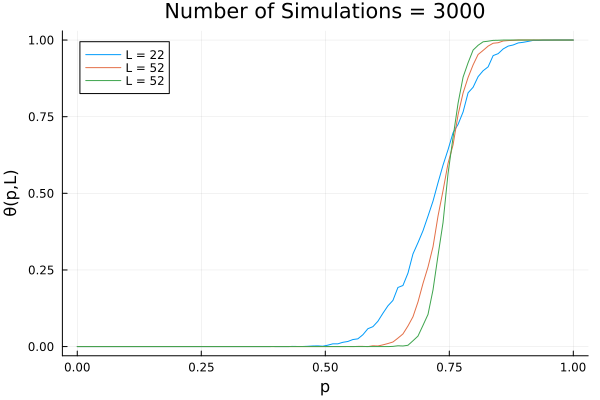

In [5]:
nsim = 3000
L1 = 20 + 2 
L2 = 50 + 2
L3 = 100 + 2
w = [-1,-1]
s = [1.0,1.0]

p = range(0,1,100)
freq1 = map(x -> MC_prll_wind(nsim,L1,x) , p)
freq2 = map(x -> MC_prll_wind(nsim,L2,x) , p)
freq3 = map(x -> MC_prll_wind(nsim,L3,x) , p)

p2 = plot(p,freq1 , label = "L = $(L1)")
plot!(p,freq2 , label = "L = $(L2)")
plot!(p,freq3 , label = "L = $(L2)")
xlabel!("p")
ylabel!("θ(p,L)")
title!("Number of Simulations = $(nsim)")